In [1]:
# E-commerce Furniture Sales Prediction using Machine Learning

# Objective:** Predict the number of furniture items sold (`sold`) using product details such as price, discount, shipping tags, and product titles.

# Dataset:** 2000 entries of furniture products from AliExpress.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder


In [3]:

df = pd.read_csv("ecommerce_furniture_dataset.csv")
df.head()

,productTitle,originalPrice,price,sold,tagText
0,Dresser For Bedroom With 9 Fabric Drawers Ward...,NaN,$46.79,600,Free shipping
1,Outdoor Conversation Set 4 Pieces Patio Furnit...,NaN,$169.72,0,Free shipping
2,Desser For Bedroom With 7 Fabric Drawers Organ...,$78.4,$39.46,7,Free shipping
3,"Modern Accent Boucle Chair,Upholstered Tufted ...",NaN,$111.99,0,Free shipping
4,Small Unit Simple Computer Desk Household Wood...,$48.82,$21.37,1,Free shipping


In [4]:
#Data Preprocessing

# 1. Drop rows with missing target (sold)
df = df.dropna(subset=['sold'])

# 2. Fill missing text columns
df['productTitle'] = df['productTitle'].fillna('')
df['tagText'] = df['tagText'].fillna('Unknown')

# 3. Clean numeric columns (remove $ and ,)
for col in ['price', 'originalPrice']:
    df[col] = (
        df[col].astype(str)
        .str.replace('$', '', regex=False)
        .str.replace(',', '')
        .replace('nan', np.nan)
        .astype(float)
    )

# 4. Fill missing numeric values with median
df['originalPrice'] = df['originalPrice'].fillna(df['originalPrice'].median())
df['price'] = df['price'].fillna(df['price'].median())

# 5. Encode categorical (fresh LabelEncoder every time)
le = LabelEncoder()
df['tagText_encoded'] = le.fit_transform(df['tagText'].astype(str))
print("TagText encoding mapping:", dict(zip(le.classes_, le.transform(le.classes_))))


# 6. Feature engineering
df['discount_percentage'] = ((df['originalPrice'] - df['price']) / df['originalPrice']) * 100
df['revenue'] = df['price'] * df['sold']

# 7. TF-IDF for productTitle
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=500)
tfidf_matrix = tfidf.fit_transform(df['productTitle'].astype(str))
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=[f'title_tfidf_{i}' for i in range(tfidf_matrix.shape[1])])
df = pd.concat([df.reset_index(drop=True), tfidf_df], axis=1)

# 8. Drop irrelevant columns
irrelevant_cols = [col for col in ['productId', 'imageUrl', 'productUrl', 'productTitle', 'tagText'] if col in df.columns]
df = df.drop(columns=irrelevant_cols)


df.head()

TagText encoding mapping: {'+Shipping: $1,097.18': np.int64(0), '+Shipping: $1,115.86': np.int64(1), '+Shipping: $1,323.31': np.int64(2), '+Shipping: $104.89': np.int64(3), '+Shipping: $106.05': np.int64(4), '+Shipping: $106.13': np.int64(5), '+Shipping: $109.18': np.int64(6), '+Shipping: $110.64': np.int64(7), '+Shipping: $112.1': np.int64(8), '+Shipping: $12.03': np.int64(9), '+Shipping: $12.82': np.int64(10), '+Shipping: $120.25': np.int64(11), '+Shipping: $122.29': np.int64(12), '+Shipping: $129.03': np.int64(13), '+Shipping: $13.95': np.int64(14), '+Shipping: $132.48': np.int64(15), '+Shipping: $134.27': np.int64(16), '+Shipping: $14.91': np.int64(17), '+Shipping: $14.97': np.int64(18), '+Shipping: $140.27': np.int64(19), '+Shipping: $141.75': np.int64(20), '+Shipping: $142.23': np.int64(21), '+Shipping: $150.28': np.int64(22), '+Shipping: $151.69': np.int64(23), '+Shipping: $168.91': np.int64(24), '+Shipping: $170.31': np.int64(25), '+Shipping: $171.49': np.int64(26), '+Shipping:

,originalPrice,price,sold,tagText_encoded,discount_percentage,revenue,title_tfidf_0,title_tfidf_1,title_tfidf_2,title_tfidf_3,...,title_tfidf_490,title_tfidf_491,title_tfidf_492,title_tfidf_493,title_tfidf_494,title_tfidf_495,title_tfidf_496,title_tfidf_497,title_tfidf_498,title_tfidf_499
0,88.31,46.79,600,99,47.016193,28074.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.103482,0.0,0.0,0.00000,0.0,0.0,0.0,0.0
1,88.31,169.72,0,99,-92.186615,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0
2,78.40,39.46,7,99,49.668367,276.22,0.0,0.0,0.0,0.0,...,0.0,0.0,0.115638,0.0,0.0,0.00000,0.0,0.0,0.0,0.0
3,88.31,111.99,0,99,-26.814630,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0
4,48.82,21.37,1,99,56.226956,21.37,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.41898,0.0,0.0,0.0,0.0


In [5]:
print(df.shape)
print(df.info())
print(df.describe())


(2000, 506)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Columns: 506 entries, originalPrice to title_tfidf_499
dtypes: float64(504), int64(2)
memory usage: 7.7 MB
None
       originalPrice        price          sold  tagText_encoded  \
count    2000.000000  2000.000000   2000.000000      2000.000000   
mean      129.149355   156.560020     23.493500        96.250000   
std       220.526269   176.936735    254.094061        12.967404   
min         3.630000     0.990000      0.000000         0.000000   
25%        88.310000    48.530000      1.000000        99.000000   
50%        88.310000   114.080000      3.000000        99.000000   
75%        88.310000   193.490000      9.000000        99.000000   
max      3265.130000  2876.380000  10000.000000       100.000000   

       discount_percentage        revenue  title_tfidf_0  title_tfidf_1  \
count          2000.000000    2000.000000    2000.000000    2000.000000   
mean            -56.887668    1090.5240

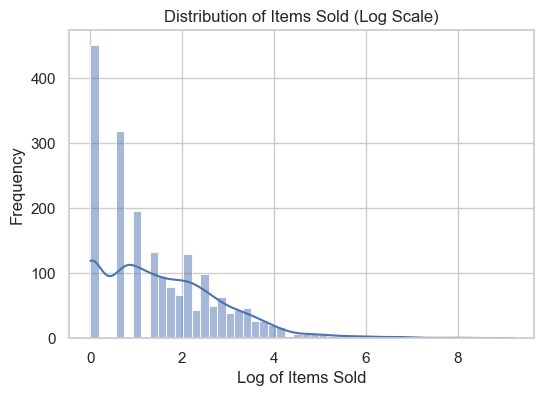

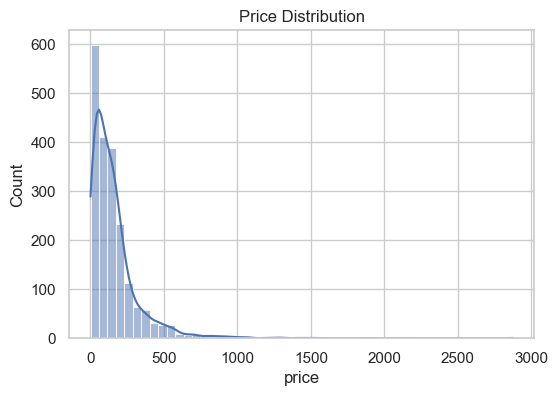

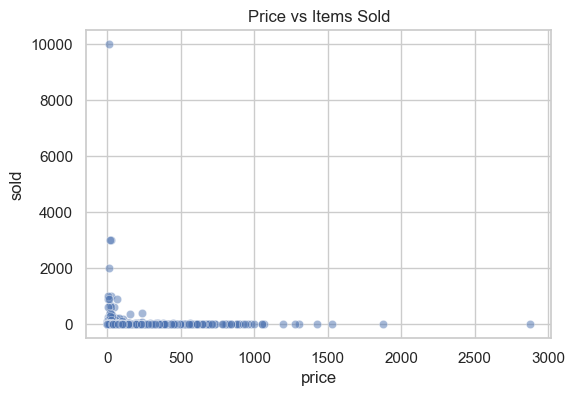

C:\Users\itzme\AppData\Local\Temp\ipykernel_11912\292100027.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_products.index, y=top_products.values, palette="viridis")


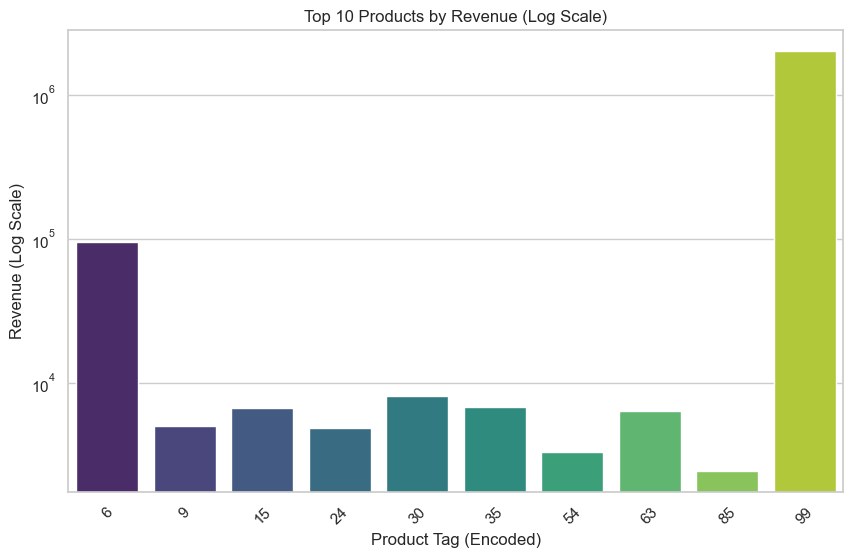

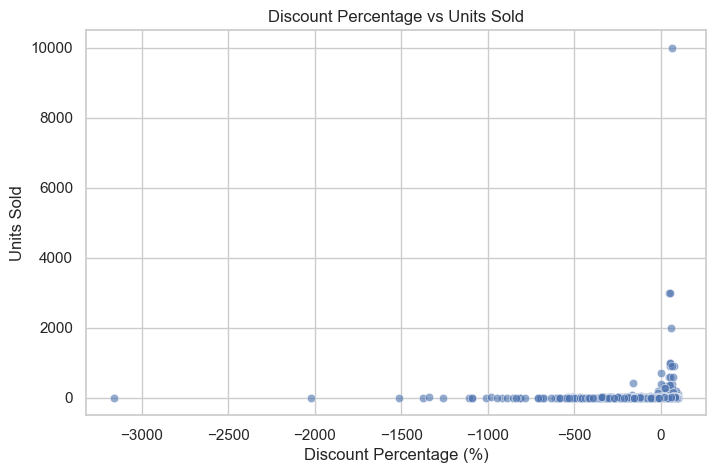

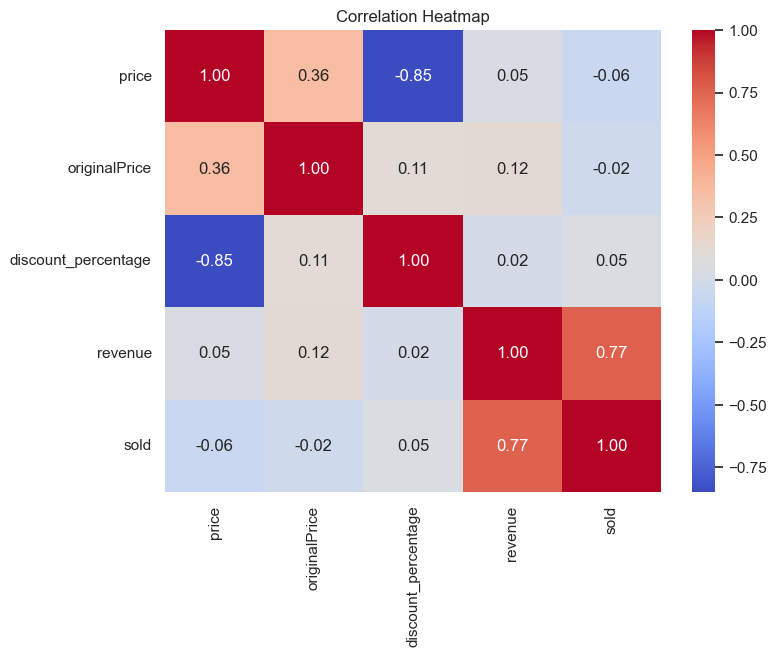

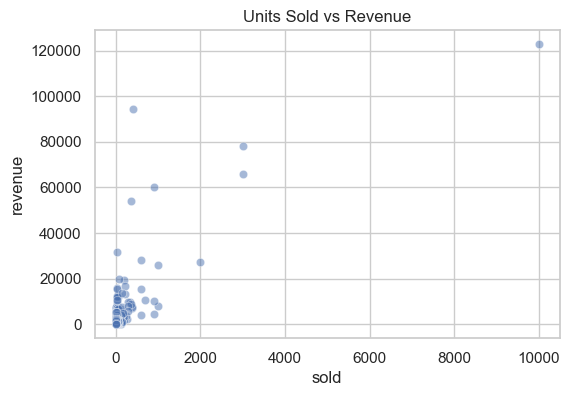

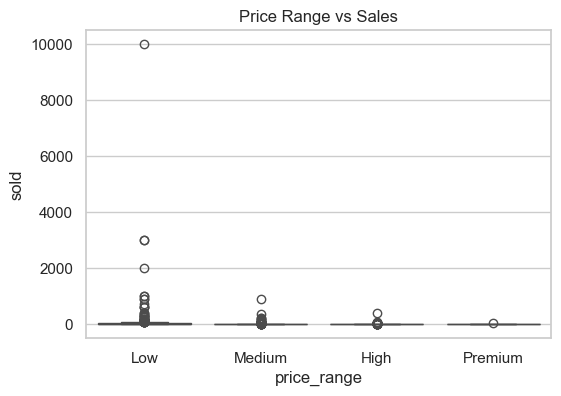

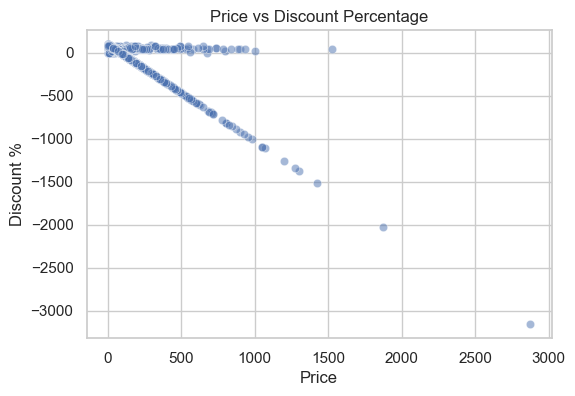

C:\Users\itzme\AppData\Local\Temp\ipykernel_11912\292100027.py:88: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='has_discount', y='sold', data=df, estimator=np.mean, ci=None)


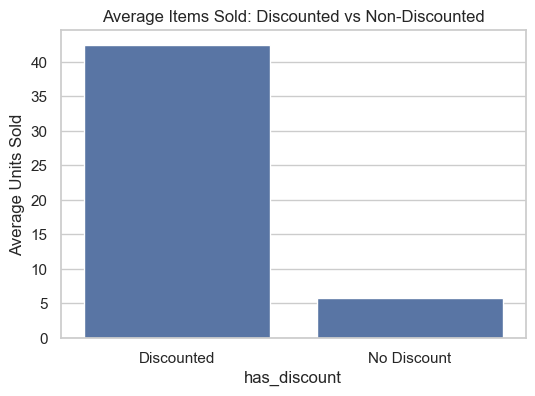

In [6]:
# ================================
# Exploratory Data Analysis (EDA)
# ================================

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Set plot style
sns.set(style="whitegrid")

# 1. Distribution of Target (sold)
plt.figure(figsize=(6,4))
sns.histplot(np.log1p(df['sold']), bins=50, kde=True)  # log1p = log(1+x) safe for 0
plt.title("Distribution of Items Sold (Log Scale)")
plt.xlabel("Log of Items Sold")
plt.ylabel("Frequency")
plt.show()

# 2. Distribution of Price
plt.figure(figsize=(6,4))
sns.histplot(df['price'], bins=50, kde=True)
plt.title("Price Distribution")
plt.show()

# 3. Price vs Sold
plt.figure(figsize=(6,4))
sns.scatterplot(x='price', y='sold', data=df, alpha=0.5)
plt.title("Price vs Items Sold")
plt.show()

# 4.Top 10 products by revenue
top_products = df.groupby('tagText_encoded')['revenue'].sum().sort_values(ascending=False).head(10)

# Bar chart
plt.figure(figsize=(10,6))
sns.barplot(x=top_products.index, y=top_products.values, palette="viridis")
plt.yscale("log")  # 🔑 this line makes it log scale
plt.title("Top 10 Products by Revenue (Log Scale)")
plt.xlabel("Product Tag (Encoded)")
plt.ylabel("Revenue (Log Scale)")
plt.xticks(rotation=45)
plt.show()

# 5. Discount vs Units Sold
plt.figure(figsize=(8,5))
sns.scatterplot(data=df, x='discount_percentage', y='sold', alpha=0.6)

plt.title("Discount Percentage vs Units Sold")
plt.xlabel("Discount Percentage (%)")
plt.ylabel("Units Sold")
plt.show()

# 6. Correlation Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df[['price','originalPrice','discount_percentage','revenue','sold']].corr(),
            annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# 7. Revenue vs Sold
plt.figure(figsize=(6,4))
sns.scatterplot(x='sold', y='revenue', data=df, alpha=0.5)
plt.title("Units Sold vs Revenue")
plt.show()

# 8. Price Range vs Sold
df['price_range'] = pd.cut(df['price'], 
                           bins=[0,50,200,1000,5000], 
                           labels=['Low','Medium','High','Premium'])
plt.figure(figsize=(6,4))
sns.boxplot(x='price_range', y='sold', data=df)
plt.title("Price Range vs Sales")
plt.show()

# 9. Price vs Discount % (Scatter Plot)
plt.figure(figsize=(6,4))
sns.scatterplot(x='price', y='discount_percentage', data=df, alpha=0.5)
plt.title("Price vs Discount Percentage")
plt.xlabel("Price")
plt.ylabel("Discount %")
plt.show()

# 10. Discounted vs Non-Discounted Products (Sales Impact)
df['has_discount'] = np.where(df['discount_percentage'] > 0, 'Discounted', 'No Discount')

plt.figure(figsize=(6,4))
sns.barplot(x='has_discount', y='sold', data=df, estimator=np.mean, ci=None)
plt.title("Average Items Sold: Discounted vs Non-Discounted")
plt.ylabel("Average Units Sold")
plt.show()



Model Performance Comparison:

               Model           MSE  R² Score
0  Linear Regression  18287.763235 -2.335041
1      Random Forest   1801.807727  0.671414
2  Gradient Boosting    483.265843  0.911869


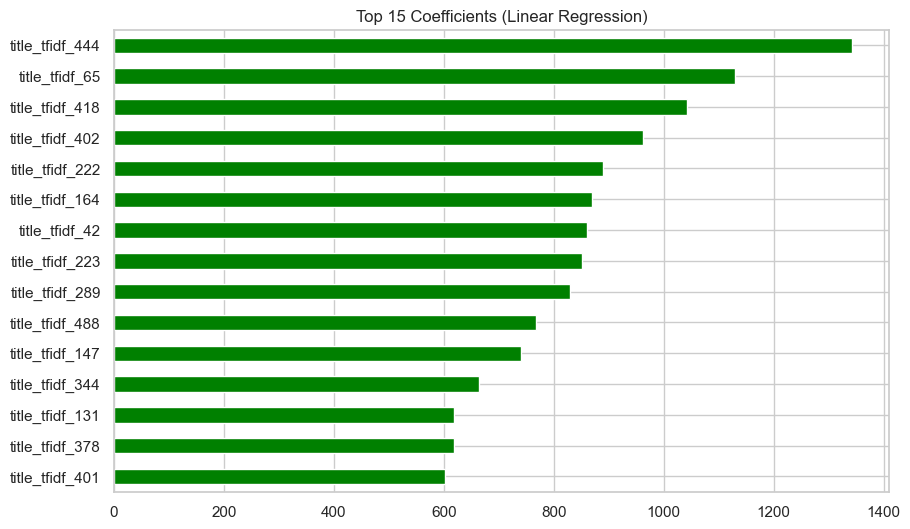

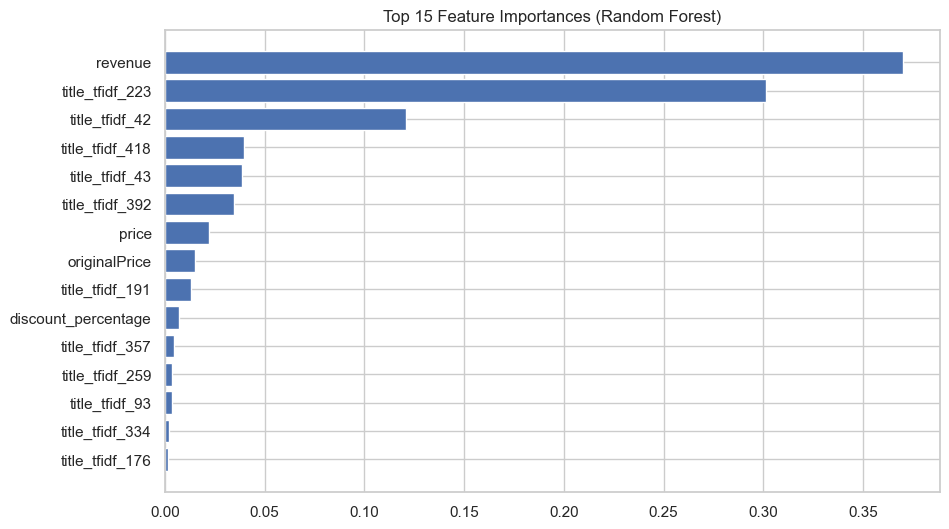

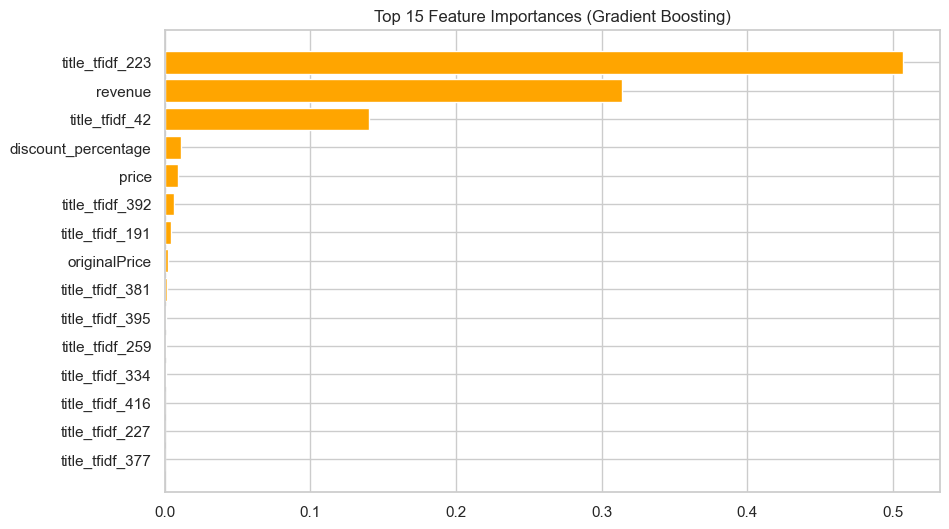

In [7]:
# ================================
# Model Selection, Training & Evaluation
# ================================

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# Fix: Drop non-numeric categorical columns
# -------------------------------
drop_cols = ['sold', 'price_range', 'has_discount', 'sold_range']
X = df.drop(columns=[c for c in drop_cols if c in df.columns])
y = df['sold']

# -------------------------------
# Train-Test Split
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -------------------------------
# Initialize Models
# -------------------------------
lr_model = LinearRegression()
rf_model = RandomForestRegressor(n_estimators=200, random_state=42)
gb_model = GradientBoostingRegressor(
    n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42
)

# -------------------------------
# Train Models
# -------------------------------
lr_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
gb_model.fit(X_train, y_train)

# -------------------------------
# Predictions
# -------------------------------
y_pred_lr = lr_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)
y_pred_gb = gb_model.predict(X_test)

# -------------------------------
# Evaluation
# -------------------------------
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

mse_gb = mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

# -------------------------------
# Results Table
# -------------------------------
results = {
    "Model": ["Linear Regression", "Random Forest", "Gradient Boosting"],
    "MSE": [mse_lr, mse_rf, mse_gb],
    "R² Score": [r2_lr, r2_rf, r2_gb]
}

results_df = pd.DataFrame(results)
print("\nModel Performance Comparison:\n")
print(results_df)

# -------------------------------
# Feature Importance / Coefficients
# -------------------------------

# Linear Regression Coefficients
coefs = pd.Series(lr_model.coef_, index=X.columns)
top_coefs = coefs.abs().sort_values().tail(15)  # Top 15 by absolute value

plt.figure(figsize=(10,6))
top_coefs.plot(kind='barh', color="green")
plt.title("Top 15 Coefficients (Linear Regression)")
plt.show()

# Random Forest Feature Importance
importances_rf = rf_model.feature_importances_
indices_rf = np.argsort(importances_rf)[-15:]

plt.figure(figsize=(10,6))
plt.barh(range(len(indices_rf)), importances_rf[indices_rf], align="center")
plt.yticks(range(len(indices_rf)), [X.columns[i] for i in indices_rf])
plt.title("Top 15 Feature Importances (Random Forest)")
plt.show()

# Gradient Boosting Feature Importance
importances_gb = gb_model.feature_importances_
indices_gb = np.argsort(importances_gb)[-15:]

plt.figure(figsize=(10,6))
plt.barh(range(len(indices_gb)), importances_gb[indices_gb], align="center", color="orange")
plt.yticks(range(len(indices_gb)), [X.columns[i] for i in indices_gb])
plt.title("Top 15 Feature Importances (Gradient Boosting)")
plt.show()


In [8]:
import joblib

# Put all models in a dictionary
models = {
    "Linear Regression": (lr_model, r2_lr),
    "Random Forest": (rf_model, r2_rf),
    "Gradient Boosting": (gb_model, r2_gb)
}

# Select model with highest R²
best_model_name, (best_model, best_score) = max(models.items(), key=lambda x: x[1][1])

print(f"\n✅ Best model is: {best_model_name} with R² = {best_score:.4f}")

# Save best model
joblib.dump(best_model, "best_model.pkl")
print("💾 Model saved as best_model.pkl")



✅ Best model is: Gradient Boosting with R² = 0.9119
💾 Model saved as best_model.pkl


In [9]:
# Save the TF-IDF vectorizer
joblib.dump(tfidf, "tfidf_vectorizer.pkl")
print("✅ TF-IDF vectorizer saved as tfidf_vectorizer.pkl")


✅ TF-IDF vectorizer saved as tfidf_vectorizer.pkl
